# Optimization Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate how to determine the optimal number of components for a `YPlusModel` model.

In [1]:
# General imports
from IPython.display import display, Image
    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_yplus
print("bayes_yplus version:", bayes_yplus.__version__)

from bayes_yplus import YPlusModel

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "png"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.4.3+2.g5ecf2cc
bayes_yplus version: 1.0.0+0.g85a82fa.dirty


## Simulating Data

Text(0, 0.5, 'Brightness Temperature (mK)')

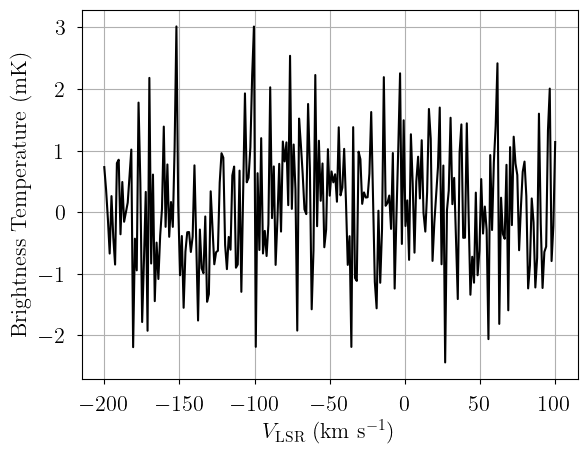

In [2]:
from bayes_spec import SpecData

# spectral axis definition
spec_axis = np.linspace(-200.0, 100.0, 251) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # mK

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(spec_axis)) # mK

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    spec_axis,
    brightness_data,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Text(0, 0.5, 'Brightness Temperature (mK)')

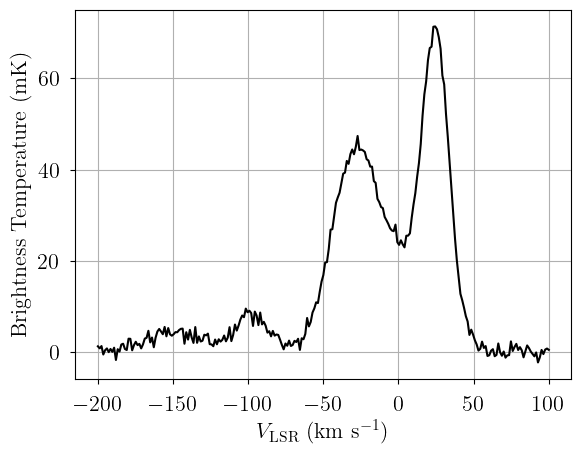

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = YPlusModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 25.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "H_area": [1500.0, 1000.0, 1250.0],
    "H_center": [-30.0, 5.0, 25.0],
    "H_fwhm": [35.0, 50.0, 20.0],
    "He_H_fwhm_ratio": [1.0, 0.8, 1.25],
    "yplus": [0.1, 0.05, 0.15],
    "rms_observation": noise,
    "observation_baseline_norm": [0.0, -0.05, 0.01], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    spec_axis,
    sim_brightness,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
data = {"observation": observation}

## Optimization

In [5]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    YPlusModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=baseline_degree,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 25.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
)
opt.add_likelihood()

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs, approx=True)

Null hypothesis BIC = 5.847e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2200
Interrupted at 2,199 [2%]: Average Loss = 12,851


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.011e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 22,300


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 9.711e+02

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 15,724


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 8.356e+02

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 4000
Interrupted at 3,999 [3%]: Average Loss = 36,659


GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = 8.796e+02

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 4200
Interrupted at 4,199 [4%]: Average Loss = 28,492


GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = 9.177e+02

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3700
Interrupted at 3,699 [3%]: Average Loss = 15,724
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, yplus_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.


GMM converged to unique solution


In [7]:
pm.summary(opt.best_model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1300.117,187.829,972.244,1642.796,6.444,4.558,845.0,1459.0,1.00
H_area[1],1102.508,198.959,790.677,1495.300,7.188,5.111,812.0,1134.0,1.00
H_area[2],1329.146,55.257,1224.646,1433.970,1.957,1.404,930.0,836.0,1.01
H_center[0],-30.484,0.656,-31.582,-29.148,0.020,0.014,1207.0,1633.0,1.00
H_center[1],-1.326,5.074,-10.090,8.164,0.175,0.124,834.0,1343.0,1.00
H_center[2],24.914,0.087,24.755,25.076,0.002,0.001,1758.0,2125.0,1.00
H_fwhm[0],34.095,1.306,31.699,36.523,0.042,0.030,965.0,1666.0,1.00
H_fwhm[1],52.879,5.625,43.556,63.744,0.205,0.145,815.0,992.0,1.01
H_fwhm[2],20.425,0.341,19.788,21.082,0.010,0.007,1170.0,1030.0,1.01
He_H_fwhm_ratio[0],1.015,0.082,0.865,1.174,0.001,0.001,3065.0,2630.0,1.00


Sampling: [observation]


Output()

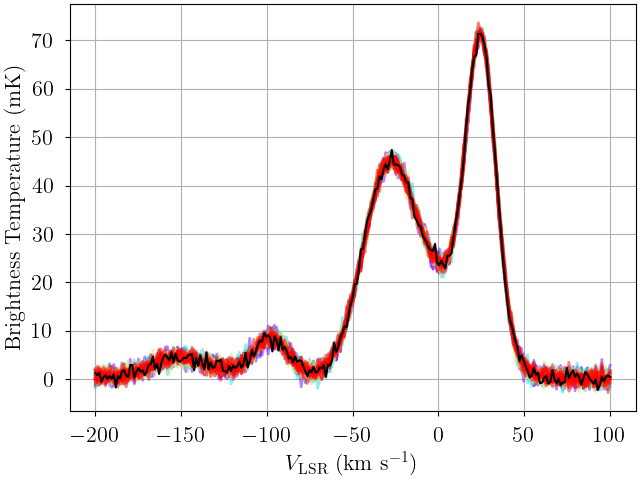

In [8]:
posterior_predictive = opt.best_model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_opt.{ext}"
)
Image(f"{figdir}/posterior_predictive_opt.{ext}")